In [87]:
import eikon as ek
import pandas as pd
from dotenv import load_dotenv; load_dotenv('../.env')

from utils import dates_list_last_day_of_month,create_dates_list, create_df_mask_from_json
import os

ek.set_app_key(os.environ['EIKON_APP_KEY'])

In [115]:
fields = ['TR.IndexJLConstituentRIC','TR.IndexJLConstituentRIC.date','TR.IndexJLConstituentRIC.change'] # no tocar

# parametros para el filtro (fecha de inicio, fecha fin, y codigo del indice de eikon)
sdate = '2000-01-01'
edate = '2023-01-01'
index_code = '.SPX'

In [116]:
# llamada para conseguir la lista de los miembros actuales (fecha fin)
current_constituents_df, err = ek.get_data(f'0#{index_code}({edate})',f'TR.RIC')

In [117]:
#si hay algun output en esta ceda hay que volver a correr la anterior
err

In [118]:
#comprobar que todo tiene buena pinta (mirar numero de filas, por ejemplo)
current_constituents_df

,Instrument,RIC
0,MMM.N,MMM.N
1,AOS.N,AOS.N
2,ABT.N,ABT.N
3,ABBV.N,ABBV.N
4,ACN.N,ACN.N
...,...,...
498,YUM.N,YUM.N
499,ZBRA.OQ,ZBRA.OQ
500,ZBH.N,ZBH.N
501,ZION.OQ,ZION.OQ


In [119]:
#limpieza de datos
current_constituents_list = current_constituents_df.replace('',pd.NA).dropna().RIC.tolist()

In [120]:
# llamada para informacion de cambios de constituents durante el periodo deseado
joiners_leavers_df, err = ek.get_data(index_code,fields,parameters={'SDate':sdate,'EDate':edate,'IC':'B'})

In [121]:
#comprobar que no hay nada raro
joiners_leavers_df

,Instrument,Constituent RIC,Date,Change
0,.SPX,RNB.N^L99,2000-01-03T00:00:00Z,Leaver
1,.SPX,NCR.N,2000-01-04T00:00:00Z,Joiner
2,.SPX,YNR.N^J00,2000-01-06T00:00:00Z,Joiner
3,.SPX,FWC.N^K02,2000-01-31T00:00:00Z,Leaver
4,.SPX,CNG.N^A00,2000-01-31T00:00:00Z,Leaver
...,...,...,...,...
1184,.SPX,FBIN.N,2022-12-19T00:00:00Z,Leaver
1185,.SPX,MBC.N,2022-12-19T00:00:00Z,Leaver
1186,.SPX,FSLR.OQ,2022-12-19T00:00:00Z,Joiner
1187,.SPX,STLD.OQ,2022-12-22T00:00:00Z,Joiner


In [123]:
joiners_leavers_df_copy = joiners_leavers_df.copy()

In [124]:
#columna de fecha a pd.datetime
joiners_leavers_df_copy['Date'] = pd.to_datetime(joiners_leavers_df_copy.Date).dt.date

In [125]:
#ordenar los cambios de constituents por fecha (de fecha fin a fecha inicial) y despues por el tipo de movimiento (Leaver antes que Joiner)
jl_df_sorted = joiners_leavers_df_copy.sort_values(['Date','Change'],ascending=False)

In [126]:
jl_df_sorted

,Instrument,Constituent RIC,Date,Change
1188,.SPX,ABMD.OQ^L22,2022-12-22,Leaver
1187,.SPX,STLD.OQ,2022-12-22,Joiner
1184,.SPX,FBIN.N,2022-12-19,Leaver
1185,.SPX,MBC.N,2022-12-19,Leaver
1186,.SPX,FSLR.OQ,2022-12-19,Joiner
...,...,...,...,...
5,.SPX,HOG.N,2000-01-31,Joiner
6,.SPX,BGEN.OQ^K03,2000-01-31,Joiner
2,.SPX,YNR.N^J00,2000-01-06,Joiner
1,.SPX,NCR.N,2000-01-04,Joiner


In [127]:
start_date = tuple(map(int,sdate.split('-')))
end_date = tuple(map(int,edate.split('-')))

#crear list de las fechas deseadas para el filtro
dates = dates_list_last_day_of_month(start_date=start_date,end_date=end_date)

In [128]:
#creando las listas de constituents en cada fecha

df = pd.DataFrame(index=dates, columns=['Index Constituents']) #crear dataframe con indice de fechas
ic_list = current_constituents_list.copy() # copia de ultimos constituents

len_dates = len(dates)
for i in range(len_dates): #iterar sobre indice de la lista de fechas
    print(str(dates[len_dates-i-1]))
    df.at[dates[len_dates-i-1],'Index Constituents'] = ic_list[:] # insertar lista de constiuents en la fila correspondiente del dataframe
    for j in jl_df_sorted.index: #iterar sobre el indice de los datos de cambios de constituents
        if dates[len_dates-i-2] < jl_df_sorted['Date'].loc[j] <= dates[len_dates-i-1]: # si la fecha actual (en la que han ocurrido cambios) está en el rango de fechas actual (para frecuencia diaria esto no importa), modificar la lista antes de inserarla en la siguente iteración
            if jl_df_sorted['Change'].loc[j] == 'Joiner': # si el cambio es Joiner quitar el miembro de la lista
                print('Removing ' + jl_df_sorted['Constituent RIC'].loc[j])
                ic_list.remove(jl_df_sorted['Constituent RIC'].loc[j])
            elif jl_df_sorted['Change'].loc[j] == 'Leaver': # si el cambio es Leaver, añadirlo a la lista
                print('Adding ' + jl_df_sorted['Constituent RIC'].loc[j])
                ic_list.append(jl_df_sorted['Constituent RIC'].loc[j])
        else:
            break

2022-12-31
Adding ABMD.OQ^L22
Removing STLD.OQ
Adding FBIN.N
Adding MBC.N
Removing FSLR.OQ
Removing MBC.N
2022-11-30
Adding TWTR.N^J22
Removing ACGL.OQ
2022-10-31
Adding NLSN.N^J22
Removing TRGP.N
Adding DRE.N^J22
Adding CTXS.OQ^J22
Removing EQT.N
Removing PCG.N
2022-09-30
Adding PENN.OQ
Adding PVH.N
Removing INVH.N
Removing CSGP.OQ
2022-08-31
2022-07-31
2022-06-30
Adding UAA.N
Adding UA.N
Adding IPGP.OQ
Removing ON.OQ
Removing KDP.OQ
Adding CERN.OQ^F22
Removing VICI.N
2022-05-31
2022-04-30
Adding DISCK.OQ^D22
Adding PBCT.OQ^D22
Adding EMBC.OQ
Removing CPT.N
Removing EMBC.OQ
2022-03-31
Adding INFO.N^B22
Adding ZIMV.OQ
Removing MOH.N
Removing ZIMV.OQ
2022-02-28
Adding XLNX.OQ^B22
Removing NDSN.OQ
Adding GPS.N
Removing CEG.OQ
2022-01-31
2021-12-31
Adding HBI.N
Adding WU.N
Adding LEG.N
Removing SEDG.OQ
Removing SBNY.OQ^C23
Removing FDS.N
Adding KSU.N^L21
Removing EPAM.N
2021-11-30
Adding ONL.N
Removing ONL.N
Adding KD.N
Removing KD.N
2021-10-31
Adding SLVM.N
Removing SLVM.N
2021-09-30
Add

<Axes: >

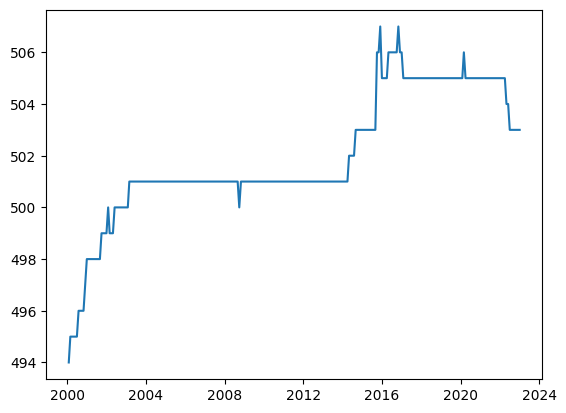

In [129]:
# longitud de la listas en cada fecha
df['Index Constituents'].apply(len).plot()

In [130]:
df

,Index Constituents
2000-01-31,"[MMM.N, ABT.N, ADBE.OQ, ADP.OQ, AEP.OQ, AES.N,..."
2000-02-29,"[MMM.N, ABT.N, ADBE.OQ, ADP.OQ, AEP.OQ, AES.N,..."
2000-03-31,"[MMM.N, ABT.N, ADBE.OQ, ADP.OQ, AEP.OQ, AES.N,..."
2000-04-30,"[MMM.N, ABT.N, ADBE.OQ, ADP.OQ, AEP.OQ, AES.N,..."
2000-05-31,"[MMM.N, ABT.N, ADBE.OQ, ADP.OQ, AEP.OQ, AES.N,..."
...,...
2022-08-31,"[MMM.N, AOS.N, ABT.N, ABBV.N, ACN.N, ATVI.OQ, ..."
2022-09-30,"[MMM.N, AOS.N, ABT.N, ABBV.N, ACN.N, ATVI.OQ, ..."
2022-10-31,"[MMM.N, AOS.N, ABT.N, ABBV.N, ACN.N, ATVI.OQ, ..."
2022-11-30,"[MMM.N, AOS.N, ABT.N, ABBV.N, ACN.N, ATVI.OQ, ..."


In [131]:
#convertir el df en un diccionario
mask_dict = df.to_dict()['Index Constituents']

In [132]:
json_fp = 'SPX_month_end_2000-2023.json' # ruta de guardado del diccionario (formato json)
csv_fp = 'SPX_month_end_2000-2023.csv' # ruta de guardado para el filtro (csv)

In [133]:
import json

str_keys_mask_dict = {str(key):value for key,value in mask_dict.items()} 

with open(json_fp,'w') as file:
    json.dump(str_keys_mask_dict,file) #guardar en json

In [135]:
mask = create_df_mask_from_json(json_fp,csv_fp) #crear el filtro y guardar en csv_fp